In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import datetime

In [2]:
car_data = pd.read_csv('car data.csv')
print(car_data.info())
print('\n % Missing Data \n\n',100*car_data.isnull().sum().sort_values(ascending = False)/len(car_data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None

 % Missing Data 

 Owner            0.0
Transmission     0.0
Seller_Type      0.0
Fuel_Type        0.0
Kms_Driven       0.0
Present_Price    0.0
Selling_Price    0.0
Year             0.0
Car_Name         0.0
dtype: float64


In [3]:
for var in car_data.columns:
    if car_data[var].dtypes == 'object':
        uniq = len(car_data[var].unique())
        print('\n ###### Categories of {} are {}'.format(var,uniq))
        freq = car_data[var].value_counts().head(5)
        print('\n{}'.format(freq))


 ###### Categories of Car_Name are 98

city             26
corolla altis    16
verna            14
fortuner         11
brio             10
Name: Car_Name, dtype: int64

 ###### Categories of Fuel_Type are 3

Petrol    239
Diesel     60
CNG         2
Name: Fuel_Type, dtype: int64

 ###### Categories of Seller_Type are 2

Dealer        195
Individual    106
Name: Seller_Type, dtype: int64

 ###### Categories of Transmission are 2

Manual       261
Automatic     40
Name: Transmission, dtype: int64


In [13]:
import datetime
car_data['car_age'] = datetime.datetime.now().year - car_data['Year']
car_data.drop(['Year','Car_Name'], axis =1, inplace =True)

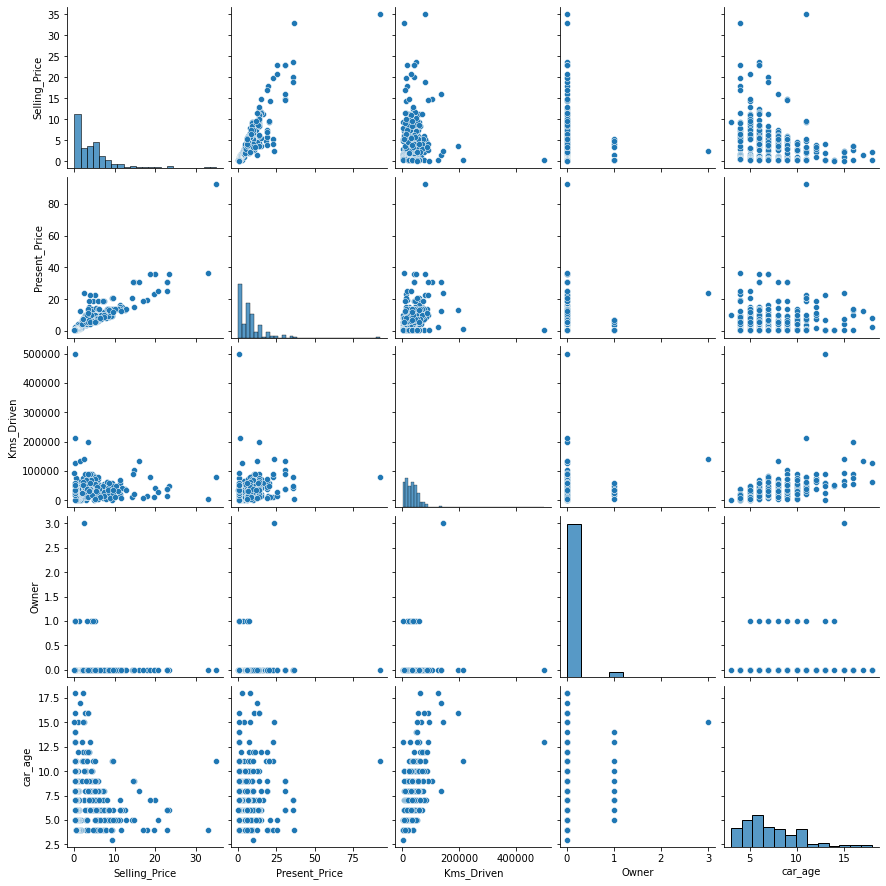

In [20]:
sns.pairplot(car_data)

In [17]:
car_data_model = pd.get_dummies(car_data, drop_first=True)
car_data_model.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,car_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,7,0,1,0,1
1,4.75,9.54,43000,0,8,1,0,0,1
2,7.25,9.85,6900,0,4,0,1,0,1
3,2.85,4.15,5200,0,10,0,1,0,1
4,4.60,6.87,42450,0,7,1,0,0,1


In [18]:
X = car_data_model.drop('Selling_Price', axis= 1)
Y = car_data_model.Selling_Price

<AxesSubplot:>

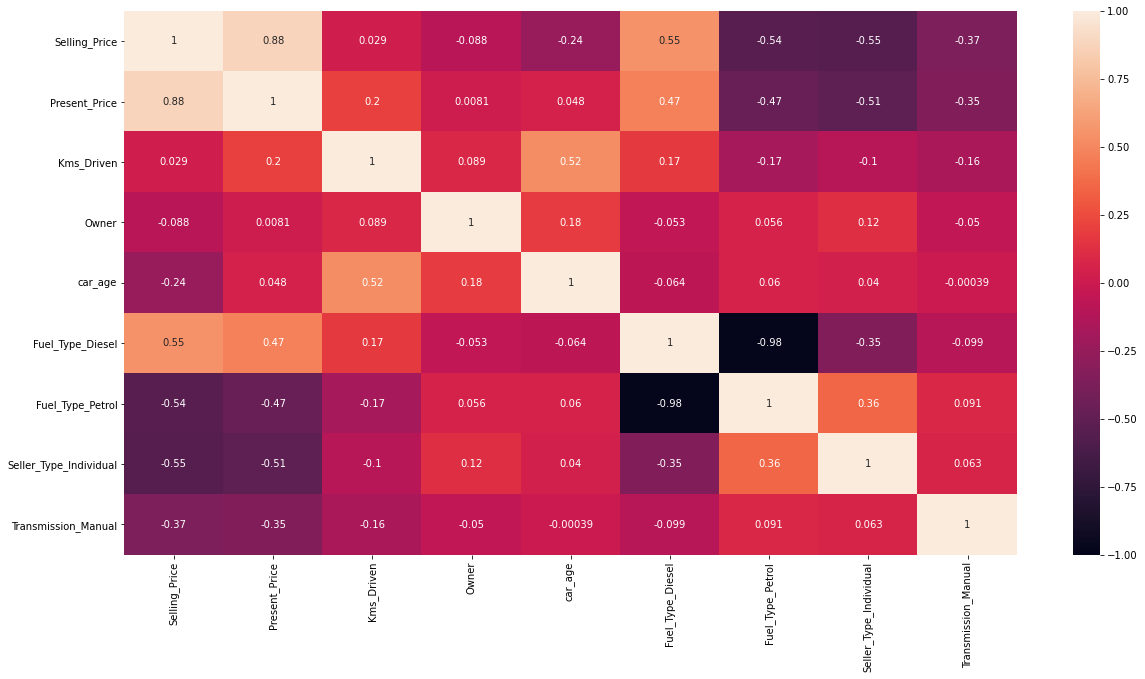

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(car_data_model.corr(),annot=True, vmin =-1, vmax=1)

# feature importance

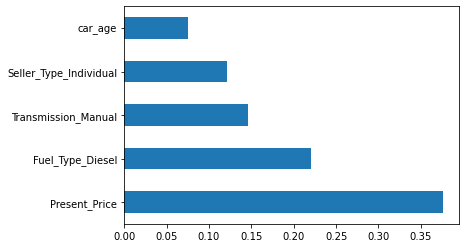

In [44]:
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
etr = ExtraTreesRegressor()
etr.fit(X, Y)
feat_imp = pd.Series(etr.feature_importances_, index=X.columns)
feat_imp.nlargest(5).plot(kind='barh')
plt.show()

In [45]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, classification_report
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=6)

In [84]:
# Hyperparameters
n_estimators= [int(x) for x in np.linspace(50,300,10)]
max_depth=[int(x) for x in np.linspace(5,10,3)]
min_samples_split= [2,3,4,5]
min_samples_leaf= [1,2,3,4,5]
# define search space
random_grid = { 'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}
print(random_grid)
# define model
rf = RandomForestRegressor()

# define evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# define search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,scoring ='neg_mean_squared_error', 
                                  cv = 5,  random_state=6, n_jobs=-1,  verbose=0)
# execute search
rf_random.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % rf_random.best_score_)
print('Best Hyperparameters: %s' % rf_random.best_params_)

# y_pred = rf_random.best_estimator_.predict(x_test)
y_pred = rf_random.predict(x_test)

{'n_estimators': [50, 77, 105, 133, 161, 188, 216, 244, 272, 300], 'max_depth': [5, 7, 10], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4, 5]}
Best Score: -5.011070059465867
Best Hyperparameters: {'n_estimators': 77, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 7}


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


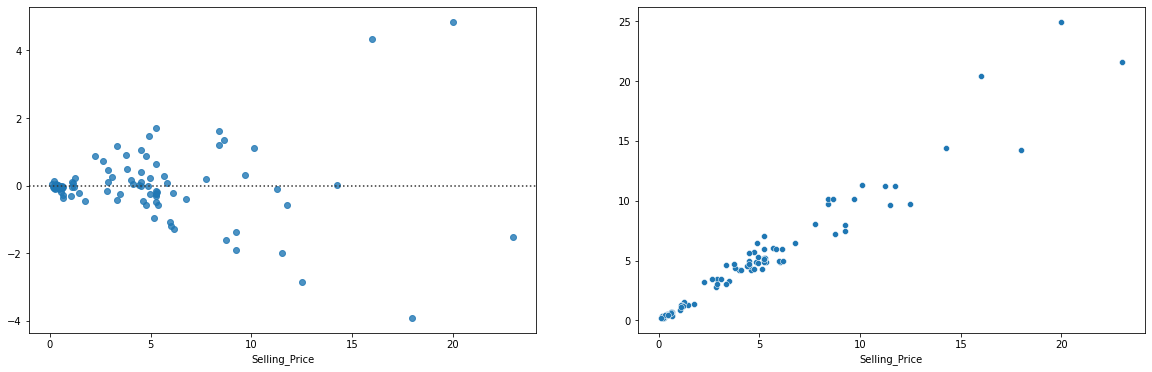

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
sns.residplot(y_test, y_pred, ax=ax1) 
sns.scatterplot(y_test,y_pred, ax=ax2) 
plt.show()

In [81]:
print('R^2:',round(rf_random.best_estimator_.score(x_test, y_test),2)) # Return the coefficient of determination R^2 of the prediction.
# adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error
print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),1))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_pred),1))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),1))

R^2: 0.97
Mean Absolute Error: 0.6
Mean Squared Error: 0.7
Root Mean Squared Error: 0.8


In [86]:
import pickle
# open a file where you want to store model
file = open('car_model.pkl', 'wb')
# save the model into that file
# pickle.dump(rf_random.best_estimator_, file)
pickle.dump(rf_random, file)